# Optimization 

The goal of this notebook is just to dip your toes into the realm of optimization which is arguably the most important research topic today - all of ML relies on being able to optimize functions ASAP.

# Exposition

Optimization is very easy to intuitively see what the goal is. We have a task like we want to feed the poor. This is either yes or no - alongside this objective, we desire to minimize the costs so as to be able to feed everyone which forms a constraint in our system. Alongside this cost constraint, we could impose a nutritional constraint where we would like to maximize the nutritional value as well. These contrast with each other in that as one becomes more and more satisfied, the other becomes less satisfied (lower cost = lower nutritional value generally) and so optimization creates a difficult, but easy to understand objective where we desire to find the best solution or food layout given and admissible set of choices to begin with.

## The Setup of Optimization Tasks

The problem we are interested in is nonlinear optimization and our problem can be more formally stated as follows: let $x$ be an $n$-dimensional real vector: 

$$x=\left(x^{(1)},\dots,x^{(n)}\right)^T\in\mathbb{R}^n,$$

and $f_0(\cdot),\dots,f_m(\cdot)$ be some real-valued functions defined on a set $Q\subset \mathbb{R^n}$. Nesterov's book focuses on problems of the minimization problem

$$\min\limits_{x\in Q} f_0(x)$$

such that 

$$f_j(x)\& 0,\;\;\; j=1,\dots,m,$$

where $\&$ could be $\leq, \geq,$ or $=$. Here we denote $f_0(\cdot )$ as the **objective function** and 

$$f(x)=\left(f_1(x),\dots,f_m(x)\right)^T$$

is called the vector of **functional constraints**, the set $Q$ is called the **basic feasible set**, and we call the **entire feasible set** as 

$$\mathcal{F} = \left\{x\in Q: f_j(x)\leq 0,j=1,\dots,m\right\}$$

which basically denotes the points satisfying the constraints of those tested from the basic feasible set. We take the minimization of $f_0(\cdot)$ above but as equally valid, we could have taken $-f(\cdot)$ if we desired a maximization of $f(\cdot)$. 

Optimization algorithms and techniques are generally well-defined and intended for an entire class of problems - not function by function of course. Understanding the class that a particular problem belongs to is the most important step in being able to solve it or cannot. With that in mind, we have a nice classification of optimization problem types based on the functions involved:

- **Constrained problems** where $\mathcal{F}$ is a proper subset of $\mathbb{R}^n$

- **Unconstrained problems** where $\mathcal{F}$ spans all of $\mathbb{R}^n$

- **Smooth problems** where the objective function and functional constraints are all smooth (continuous derivatives)

- **Nonsmooth problems** where some or all of the functions above are non-differentiable

- **Linearly constrained problems** where the functional constraints are affine (a linear function coupled with a translation - not centered at the origin):

$$f_j(x) = \sum\limits_{i=1}^n a_j^{(i)}x^{(i)} + b_j.$$

- **Linear optimization problems** where the objective function is affine.

- **Quadratic optimization problems** where the objective function is quadratic.

- This list goes on, but these are the important ones.

Similarly, we can disect and classify problems based on the feasible set:

- The minimization problem is **feasible** (not impossible) if $\mathcal{F}\neq 0$

- The minimization problem is **strictly feasible** if there exists an $x\in Q$ such that $f_j(x)<0$ (or $f_j(x)>0$) for all inequality constrains and $f_j(x)=0$ for all equality constraints. Basically same as above, but strict inequalities only.

Finally, we also have different classes of problems for different types of solutions:

- $x^*\in\mathcal{F}$ is called a **global optimal solution** to the minimization problem if $f_0(x^*)\leq f_0(x)$ for all $x\in\mathcal{F}$. In this case, $f_0(x^*)$ is called the global optimial value of the problem.

- $x^*\in\mathcal{F}$ is called a **local solution** to the minimization problem if there exists a set $\hat{\mathcal{F}}\subset \mathcal{F}$ such that $x^*\in\hat{\mathcal{F}^\circ}$ (the interior of $\hat{\mathcal{F}}$) and $f_0(x^*)\leq f_0(x)$ for all $x\in\hat{\mathcal{F}}$ (local minimum). If $f_0(x^*)<f_0(x)$ for all $x\in\hat{\mathcal{F}}\setminus \{x^*\}$, then $x^*$ represents a strict (or isolated) local minimum.

## The Performance of Optimization Algorithms

We have a **problem $P$** inside a more broad class of problems $\mathcal{P}$ (i.e. smooth functions, second-order derivatives are continuous, etc.) and we desire to find the best **optimization method $\mathcal{M}$**. Generally our method does not have complete information about a problem (i.e. it's missing some values of the function and/or it's derivatives) and so we label the known part of the problem $P$ the **model $\Sigma$**. To solve a problem, there must be an **oracle $\mathcal{O}$** (or genie of sorts as pictured below) that answers our calls or questions. For instance, a call to the oracle could be "genie what's the value of the derivative of the objective of $P$ at $x\in\mathcal{F}$". In other words, I generally think of the oracle as simply giving us an evaluation of the function.

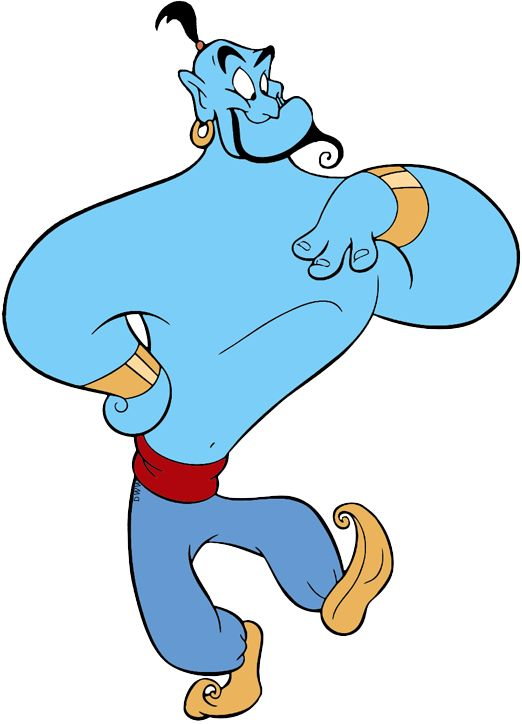

In [5]:
from IPython.core.display import Image, display
display(Image("figs/aladdin.jpg", width=300, unconfined=True))

There could also be different types of oracles. One example could be a oracle that gives us a very fine approximation of the values of a function (say within $\epsilon$ of the true value) while another could be a stochastic oracle that randomly gives us values that could have noise (think dynamical systems where we employ Kalman filters). Now if we want to evaluate a method $\mathcal{M}$ given a particular oracle $\mathcal{O}$ and model $\Sigma$, we naturally would view the *performance as the method's performance on the worst problem $P_W$* for the given model and oracle. As we have a plan for evaluating a method (or really optimization algorithm), we want to understand what exactly is the performance of a method on a single problem $P_W$. Nesterov defines it as follows:

The **performance of $\mathcal{M}$ on $P_W$** is the total amount of computational effort required by method $\mathcal{M}$ to solve the problem $P$. 

To couple this definition of what is meant by the performance, we define **solving the problem** as meaning finding an approximate solution to $\mathcal{P}$ with some degree of accuracy $\epsilon > 0$. We will denote $\tau_\epsilon$ as the stopping criteria - this for instance could be $\tau_\epsilon = f(x_k) - f(x_{k-1})<\epsilon$. Similarly, we must define what is meant by computational effort. This can be seen as either **analytical complexity** which is the number of calls made to the oracle to solve a problem $P$ with accuracy $\epsilon$ and **arithmetical complexity** which denotes the total number of arithmetic operations necessary for solving a problem $P$ with degree of accuracy $\epsilon$. Notice that arithmetical complexity is representative of the entire running time, but generally analytical complexity is easier to compute and arithmetical complexity is a function of analytical complexity. Anyhow, to solve a problem $P\in\mathcal{P}$ with a tuple of characteristics $\mathcal{P}=(\Sigma, \mathcal{O}, \tau_{\epsilon})$, we employ the following **general iterative scheme**:

**Input**: Starting point $x_0$ and accuracy $\epsilon >0$.

**Initialization**: Set $k=0, \mathcal{J}_{-1}=\emptyset$. Here $k$ represents the **iteration counter** and $\mathcal{J}_k$ is the accumulated **informational set** (what we got from the oracle and our updates).

**Main Loop**:

**1.** Call oracle $\mathcal{O}$ at point $x_k$.

**2.** Update the informational set: $\mathcal{J}_k=\mathcal{J}_{k-1}\bigcup (x_k,\mathcal{O}(x_k))$.

**3.** Apply the rules of method $\mathcal{M}$ to $\mathcal{J}_k$ and generate a new point $x_{k+1}$.

**4.** Check criterion $\tau_\epsilon$. If yes, then form an output $\bar{x}$. Otherwise set $k=k+1$ and go to step one.

In order for us to obtain analytical complexity bounds, we must make a standard assumption which is called the **local black box concept**:

**1.** The only information available for the numerical scheme is the answer of the oracle.

**2.** The oracle is *local*: A small variation of the problem far enough from the test point $x$, which is compatible with the description of the problem class, does not change the answer $x$.

Now why do we make these assumptions is probably the most natural question after hearing this? For 1., problems of interest today are very complicated dynamical systems like neural networks and more complicated compositions of functions and the oracle is our only sourrce of information - we do not know how to inherently compute some of the values without it or the problem would be trivially solved without needing optimization. An example of a problem not satisfying this constraint would be the minimum of $y=x^2$ - there's no need for optimization here when basic calculus works like a charm. As for the latter assumption, I have no idea what constitutes a small variation of the problem but within the problem class means - I am guessing that this means that the calls are consistent for problems within the class which would imply that we can guarantee analytical bounds for all of the class but that seems dumb/obvious. 

Finally, for minimization problems phrased in this manner, we generally call it a **functional model** where assumptions are related to the smoothness of the functions in the problem. Thus, we have different types of oracles to clarify the problem type:

- **Zero-order oracle**: returns the function value $f(x)$

- **First-order oracle**: returns the function value $f(x)$ and the gradient $\nabla f(x)$

- **Second-order oracle**: returns $f(x)$, the gradient $\nabla f(x)$, and the Hessian $\nabla^2 f(x)$.

## Optimization Technique Objectives

**1. General Global Optimization** 

- **Goals**: find a global minimum

- **Functional Class**: Continuous functions

- **Oracle**: 0 or 1 or 2 order black box

- **Desired properties**: convergence to a global minimum

- **Problem sizes**: sometimes, we can solve problems with many variables, but there is no guarantee even for small problems

**1. General Nonlineaer Optimization** 

- **Goals**: find a local minimum

- **Functional Class**: Differentiable functions

- **Oracle**: 1 or 2 order black box

- **Desired properties**: fast convergence to a local minimum

- **Problem sizes**: up to several thousand variables

**1. Black Box Convex Optimization** 

- **Goals**: find a global minimum

- **Functional Class**: Convex sets and functions

- **Oracle**: 1 or 2 order black box

- **Desired properties**: convergence to a global minimum. The rate of convergence can depend on the dimensions

- **Problem sizes**: several thousand variables for second-order methods, and several million for the first order schemes

**1. Structural Optimization** 

- **Goals**: find a global minimum

- **Functional Class**: Simple convex sets and functions with explicit minimax stucture

- **Oracle**: 2 order black box for special barrier functions and modified first-order Black box 

- **Desired properties**: fast convergence to a global minimum. The rate of convergence depends on the structure of the problem

- **Problem sizes**: sometimes up to several million variables

## Local Methods in Unconstrained Minimization

The general goal in Nonlinear optimization is to find a local minimum of a differentiable function. Iterative procedures in optimization are based on the concept of relaxation sequences:

- A sequence of real numbers $\{a_k\}_0^\infty$ is called a relaxation sequence if 

$$a_{k+1}\leq a_k\;\;\;\forall k\geq 0.$$

If the sequnce is bounded below, then $\{a_k\}$ is convergent. To implement the idea of relaxation, we generally harness the power of Taylor expansion of functions to provide approximations to functions. 

If $f(\cdot)$ is differentiable at $\bar{x}\in\mathbb{R}^n$, then for any $y\in\mathbb{R}^n$, we have by first-order Taylor expansion

$$f(y)=f(\bar{x})+\langle \nabla f(\bar{x}),y-\bar{x}\rangle + o\left(\lVert y-\bar{x}\rVert\right)$$

where $o:[0,\infty)\rightarrow \mathbb{R}$ is a function s.t. for $r\geq 0$, we have

$$\lim\limits_{r\downarrow 0} \frac{o(r)}{r}=0.$$




# Definitions

Apologies in advance as algorithms cannot be written in nice pseudo-code in native Jupyter, so I have some jank bulleted lists

### Lipschitz Continuity

A real-valued function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is Lipschitz continuous on $B_n$ with constant $L$ if

$$|f(x)-f(y)|\leq L\lVert x-y\rVert_\infty$$

for all $x,y\in B_n$.

### Uniform Grid Method

Uniform grid method intuitively takes a sample space and initializes points uniformly within the rectangle or ball. Once these points are initialized, we simply compute all values and return the minimum to solve the objective function for the smallest value. Instead of searching over all the real numbers, this simple, yet efficient method (generally for functions of dimension less than or equal to 2) finds extrema quite accurately. 

*Uniform Grid Method Algorithm*: 

* *Input*: a function $f$, an n-dimensional box $B_n$, and $p$ that is a proxy for the distance between points chosen (larger $p$ means finer partition)

* Initialize $p^n$ points to call the function at as follows

$$x_\alpha = \left(\frac{2i_1 - 1}{2p},\dots,\frac{2i_n-1}{2p}\right)^T,$$

where $\alpha = (i_1,\dots,i_n)\in\{1,\dots,p\}=[p]$.

* We evaluate the function $p^n$ times and find the $\bar{x}\in x_\alpha$ that minimizes $f$.

* Return the pair $\left(\bar{x}, f(\bar{x})\right)$.

### Unimodal

A real-valued function $f$ is unimodal on an interval if there is a unique value $x^*$ in the interval such that $f(x^*)$ is the minimum of $f$ on the interval, and $f$ is strictly decreasing for $x\leq x^*$ and strictly increasing for $x^*\leq x$.

### Golden Section Search

If we suppose that $f$ is unimodal on the interval $[a,b]$ and we desire to find the minimum, then there are two key goals for admissible algorithms: 1) minimize the number of function calls and 2) reduce the search interval size each time. 

Consider first the intuitive way of finding the minimum: first find the midpoint of $[a,b]$ which is $m=a+b/2$. Then evaluate $f$ at $m-\frac{\delta}{2}$ and $m+\frac{\delta}{2}$ for small $\delta$. If $f(m-\frac{\delta}{2})<f(m+\frac{\delta}{2})$, we know the minimum cannot lie in $[m+\frac{\delta}{2},b]$ as the function is unimodal over the interval. Thus the next interval we would look at is $[a,m-\frac{\delta}{2}]$ otherwise we'd look at $[m+\frac{\delta}{2},b]$. Notice that we can exclude the interval $(m-\frac{\delta}{2},m+\frac{\delta}{2})$ as $\delta$ is very small. This method halves the search interval at each step but it requires two function calls to find $f(m-\frac{\delta}{2})$ and $f(m+\frac{\delta}{2})$. Let us call this method the midpoint section search. 

Let us see if we can obtain a similar reduction in the interval at each step but only use one function call. If $f(x_1)<f(x_2)$, then our new interval is reduced to $[a,x_2]$ so 

$$x_2 - a = c(b - a)\iff x_2 = (1 - c)a + cb.$$

Otherwise, if $f(x_1)>f(x_2)$, then our interval is $[x_1,b]$ and 

$$b - x_1 = c(b - a)\iff x_1 = ca + (1 - c)b.$$



*Golden Section Search Algorithm* 

* *Input*: a function $f$, a unimodal interval for $f$: $[a,b]$, and an error tolerance $tol$

* $\tau = \frac{\sqrt{5} - 1}{2}$

* $x_1 = a + (1-\tau)(b-a)$

* $f_1 = f(x_1)$

* $x_2 = a + \tau (b-a)$

* $f_2 = f(x_2)$


* *while* $\left((b - a) > tol\right)$ *do*
    * *if* $(f_1 > f_2)$ *then*
        * $a = x_1$

        * $x_1 = x_2$

        * $f_1 = f_2$

        * $x_2 = a + \tau (b-a)$

        * $f_2 = f(x_2)$
   
    * *else*
        * $b = x_2$

        * $x_2 = x_1$

        * $f_2 = f_1$

        * $x_1 = a + (1-\tau)(b-a)$

        * $f_1 = f(x_1)$

    * *end*
    
* *end*



# Algorithm Implementation

This section is designated to implementing the optimization algorithms and benchmarking performance against datasets. 

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.animation import FuncAnimation

In [2]:
# timer class to benchmark running times of algorithms
class Timer: 
    """Record multiple running times"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start timer"""
        self.tik = time.time()

    def stop(self):
        """Stop timer and record the time in a list"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg_time(self):
        """Return average time"""
        return sum(self.times) / len(self.times)

    def sum_time(self):
        """Return sum of time"""
        return sum(self.times)

    def cumsum_time(self):
        """Return accumulated time"""
        return np.array(self.times).cumsum().tolist()

## Golden Section Search

**Note**: Benchmarking this particular algorithm in relation to other ones is not intelligent in the slightest as this algorithm assumes we already are given a unimodal interval - useful only in theory.

In [3]:
def golden_section_search(f, a, b, tol):
    """
    :param: f - function taking a float as input and float as output 
    :param: a - float, specifying min point on the unimodal interval for f
    :param: b - float, specifying max point on the unimodal interval for f
    :param: tol - float, specifying tolerance for how smallest interval to search
    :return: minimum - float, where f is smallest on the interval
    """
    tau = (np.sqrt(5) - 1) / 2
    x_1 = a + (1 - tau) * (b - a)
    f_1 = f(x_1)
    x_2 = a + tau * (b - a)
    f_2 = f(x_2)
    
    while (b - a) > tol:
        if f_1 > f_2:
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau * (b - a)
            f_2 = f(x_2)
        else:
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1 - tau) * (b - a)
            f_1 = f(x_1)
            
    return f_1

# Example function
def quadratic_func(x):
    return x ** 2

min_point = -10
max_point = 10
tol = 0.1

# Time how long it takes to find min
timer = Timer()
timer.start()
min_est = golden_section_search(f=quadratic_func, a=min_point, b=max_point, tol=tol)
print(f'Estimated Minimum: {min_est:.7f}')
print(f'Time: {timer.stop():.7f} sec')

Estimated Minimum: 0.0000537
Time: 0.0005488 sec


## Examples

### Lipschitz Continuity

**Example 1**: For the function $f(x)=\alpha x + b$, we have for all $x_1,x_2\in\mathbb{R}$ that

$$|f(x_1)-f(x_2)|=|\alpha(x_1-x_2)|\leq |\alpha|\cdot |x_1-x_2|$$

implying that it is indeed Lipschitz.

**Example 2**: For any Lipschitz continuous function, uniform grid search yields that for a local extrema $x^*$ and a guess $\bar{x}$ on a uniform box, we have

$$|f(\bar{x})-f(x^*)|\leq \frac{L}{2}.$$

Why well notice that as $x_i\in[0,1]$ and $f(\cdot)$ is Lipschitz, we have

$$|f(\bar{x}) - f(x^*)|\leq L\lVert \bar{x} - x^*\rVert_\infty=L\max\limits_{k\in[n]} \left|\frac{2i_k-1}{2p}-x_k\right|$$

$$=L\max\limits_{k\in[n]} \left|\frac{i_k-px_k}{p}-\frac{1}{2p}\right|\leq L\max\limits_{k\in[n]} \left|\frac{1/2}{p}-\frac{1}{2p}\right|=\frac{L}{p}.$$

I don't agree with Nesterov's bound mentioned in Theorem 1.1.1 which is smaller. Take for instance $p$ to be odd and then $x^*$ such that $px^*$ is not an integer then the difference with $i_k$ could be at most $1/2$.

### Unimodal Functions

Clearly $y=x^2$ is unimodal over all of $\mathbb{R}$ and we can see that below. A function is unimodal again if there is a unique local minimum for some interval $[a,b]$ - uniqueness of the local minimum can be found by checking if the derivative of the function is zero or not. $y=20$ has derivative zero and we see the minimum is not unique.

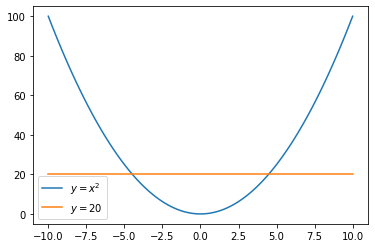

In [5]:
x = np.linspace(-10, 10, 100)
y1 = x ** 2
fig = plt.figure()
ax = plt.axes()
ax.plot(x, y1, label = "$y=x^2$")
ax.plot(x, np.repeat(20, 100), label = "$y=20$")
ax.legend()

### Golden Section Search Example

Consider the above function $y = x^2$ on the interval $[-10,10]$ where it is unimodal. We can look at the iterations of the algorithm below. This is a very simple function and as evidence, this converges to the minimum in less than 10 iterations quite quickly. 

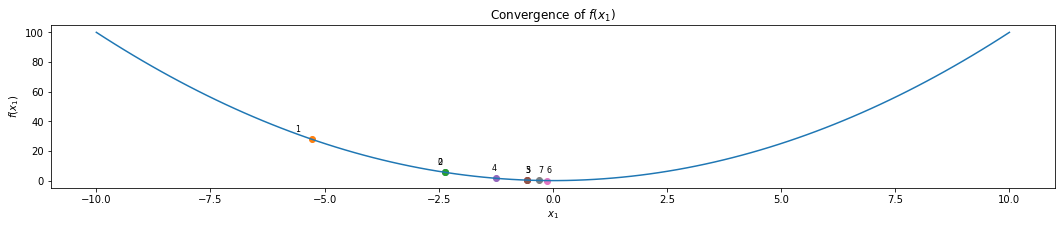

In [32]:
def quadratic_func(x):
    return x ** 2

# intializing params
a = -10
b = 10
tol = 0.1

# generate the points for plotting
start_points = []
end_points = []
start_values = []
end_values = []

tau = (np.sqrt(5) - 1) / 2
x_1 = a + (1 - tau) * (b - a)
start_points.append(x_1)
f_1 = quadratic_func(x_1)
start_values.append(f_1)
x_2 = a + tau * (b - a)
end_points.append(x_2)
f_2 = quadratic_func(x_2)
end_values.append(f_2)

while (b - a) > tol:
    if f_1 > f_2:
        a = x_1
        x_1 = x_2
        start_points.append(x_1)
        f_1 = f_2
        start_values.append(f_1)
        x_2 = a + tau * (b - a)
        end_points.append(x_2)
        f_2 = quadratic_func(x_2)
        end_values.append(f_2)
    else:
        b = x_2
        x_2 = x_1
        end_points.append(x_2)
        f_2 = f_1
        end_values.append(f_2)
        x_1 = a + (1 - tau) * (b - a)
        start_points.append(x_1)
        f_1 = quadratic_func(x_1)
        start_values.append(f_1)
                
fig, ax = plt.subplots(figsize=(18, 3))
x = np.linspace(-10, 10, 100)
y1 = x ** 2
ax.plot(x, y1, label = "$y=x^2$")
for i in range(8):
    ax.scatter(start_points[i], start_values[i])
    ax.text(start_points[i] * (1.07), start_values[i] + 5 , i, fontsize=8)
    
plt.xlabel("$x_1$")
plt.ylabel("$f(x_1)$")
plt.title("Convergence of $f(x_1)$")
plt.show()

## Theory Problems

## Problems in Vishnoi's book

### Preliminaries

**2.1**: For each of the following functions, compute the gradient and the Hessian, and write the second-order Taylor approximation

**(a)** $f(x)=\sum\limits_{i=1}^m (a_i^T x - b_i)^2$ for $x\in\mathbb{Q}^n$, where $a_1,\dots,a_m\in\mathbb{Q}^m$ and $b_1,\dots,b_m\in\mathbb{Q}$.

**(b)** $f(x)=\log\left(\sum\limits_{j=1}^m e^{\langle x,v_j\rangle}\right)$, where $v_1,\dots,v_m\in\mathbb{Q}^n$

**(c)** $f(X)=\text{Tr}(AX)$, where $A$ is a symmetric $n\times n$ matrix and $X$ runs over symmetric matrices.

**(d)** $f(X)=-\log \det X$, where $X$ runs over positive definite matrices.

- For (a), we have 

$$\nabla f(x) = \sum\limits_{i=1}^m 2(a_i^Tx - b_i)a_i^T$$

and 

$$H(f(x)) = J(\nabla f(x)) = $$



### Problems in Heath's book (ch. 6):

**6.1.** True or false: Points that minimize a nonlinear function are inherently less accurately determined than points for which a nonlinear function has a zero value.

- False: I do not like the wording, but I belive by less accurate he means more difficult to find. In this case it makes sense as stationary (zeros) are needed in the process of finding a minimum of a function. That is the latter also requires checking the partials and potentially higher order derivatives to verify if the point is a minimum.

**6.2.** True or false: If a function is unimodal on a closed interval, then it has exactly one minimum on the interval.

- True: By definition, we know that if there were not a unique minimum on the interval then $f$ would not be strictly decreasing and then strictly increasing after the point.

**6.3** True or false: In minimizing a unimodal function of one variable by golden section search, the point discarded at each iteration is always the point having the largest function value.

- True: If $f(x_1)<f(x_2)$, then we know $(x_2,b]$ cannot contain the minimum, so we look at $[a,x_2)$ subsequently - i.e. we take the new $b$ as $x_2$ and .

**6.4** True or false: For minimizing a real-valued function of several variables, the steepest descent method is usually more rapidly convergent than Newton's method.

## Coding Problems

asdf

# Sources

- "Scientific Computing: An Introductory Survey" by Michael Heath.
    - Cool book - used at stanford for graduate ml course
    
- "Lectures on Convex Optimization" by Yurii Nesterov
    - Book here for 227c (grad convex optimization)
    
- "Algorithms for Convex Optimization" by Vishnoi
    - Book here for 227c